# The Non-Linear Schrödinger Equation: Solitons, SSFM Simulaton, and PINNs.

## Introduction

The time-dependent linear Schrödinger equation is one of the most important equations in Quantum Mechanics; it describes how a complex-valued wavefunction changes over time under the influence of some potential $ V(x) $:

$$
i\psi_t = -\frac{1}{2}\psi_{xx} + V(x)\psi
$$

The second derivative term $ -\frac{1}{2}\psi_{xx} $ represents the dispersion term, which causes the wavefunction to spread out over time. The potential term $ V(x)\psi $ represents some external conditions of the medium. For this project, we will steer away from the linear Schrödinger equation to explore nonlinear wave dynamics. Many physical systems exhibit behaviour where the potential depends on the wavefunction itself. For example, in some systems such as in optical fibres, the wave intensity affects the medium, which in turn affects the wave, creating self-interaction. A common model and the method of choice for this project is to let the potential depend on the wave amplitude, as follows:

$$
V(x,t) = -|\psi(x,t)|^2
$$

The potential of the system depends on the wave amplitude. Substituting this potential into the linear Schrödinger equation yields the 1D Nonlinear Schrödinger Equation, the PDE we will be working on solving using numerical and machine learning methods.

$$
i\psi_t = -\frac{1}{2}\psi_{xx} - |\psi|^2 \psi.
$$

The nonlinear term $ - |\psi|^2 \psi $ produces self-focusing, pulling the wave together and acts like a self-induced potential well. The competition between the linear dispersion term and the non-linear term produces fascinating results, that will be explored in this project. When the dispersion and nonlinearity perfectly balance, solitons emerge - waves that travel without changing shape. 

### What are Solitons?

A soliton is a unique solution to certain nonlinear PDEs. It has permanent form, meaning it doesn't change shape or amplitude while travelling at constant speed. It is also localised, meaning it is confined to a specific reigon and resembles a single pulse. The focusing NLS admits a soliton solution of the form:

$$
\psi(x,t) = A\,\mathrm{sech}\!\left[B(x - vt)\right]\,e^{i(kx - \omega t)}.
$$

Breaking this equation down into parts provides info into the nature of the solitons. Looking at the real-valued part, $ A\,\mathrm{sech}\!\left[B(x - vt)\right]\ $, 'sech' gives a smooth bump, and the height and width of the soliton are controlled by A and B respectively. The complex component, $ e^{i(kx - \omega t)} $, gives the soliton a phase oscillation, where the wavenumber k determines the phase velocity and angular frequency ω relates to the dispersion relation. 

The soliton solution above comes from substituting a travelling-wave ansatz into the NLS. After real and imaginary parts are separated, a second-order nonlinear ODE is obtained, yielding the soliton solution. A full derivation of this is shown in the derivations/ folder of this project. 

### Computational methods used to solve the NLS

Two methods are going to be used to solve the NLS.

1. Split-step Fourier Method (SSFM)

This is a classical method used to solve PDEs numerically, by splitting the NLS into its linear and nonlinear components. The linear part is solved in the Fourier space, while the nonlinear part is solved in the physical space. Strang splitting (2nd order splitting) is used in this project to solve the PDE. 

2. Physics-Informed Neural Network (PINN)

A Neural Network is built using TensorFlow, trained to incorporate the NLS residual (the leftover error), boundary and initial conditions. 

The SSFM will provide the benchmark for the solutions, and will be used to determine the PINN's accuracy, to see whether machine learning methods can be used to accurately solve PDEs.

## Split-Step Fourier Method (SSFM)

Firstly, the split-step fourier method will be implemented to get an accurate solution to the NLS. As previously discussed, SSFM is based on splitting the NLS into linear and nonlinear components, with the linear part being solved in the Fourier space and the nonlinear part being solved in real space. Strang splitting is then used to combine these updates and obtain our solution.

The linear component of the NLS is as follows (the dispersion term): $$ i\psi_t = -\frac{1}{2}\psi_{xx} $$ Next, the nonlinear component of the NLS (focusing term): $$ i\psi_t = - |\psi|^2 \psi $$ The solutions to these two equations are also derived and explained clearly in the derivations/ folder.

First we import key libraries used in the SSFM, including the necessary modules for the fourier transforms. 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq, fftshift

To simulate the NLS, we need to define initial and boundary conditions. This is achieved by creating a spatial and temporal grid. The wave is simulated on an interval of length L, where: 

$$ x \in \left[-\frac{L}{2},\, \frac{L}{2}\right] $$

The interval is divided equally into N points, meaning the spacing is: $$ \Delta x = \frac{L}{N} $$

Similarly, a time step is also defined, along with a total simulation time T. The simulation is then initialised using the exact initial conditions: $$ \psi(x,0) = A\,\mathrm{sech}(Bx)\,e^{ikx} $$ 

We multiply by $e^{ikx} $ which has magnitude of 1 and therefore does not change the amplitude, but adds a phase difference. Without this the soliton solution would not change over time. 



In [22]:
#Spatial domain
N = 2 ** 13 # High N gives higher resolution
L = 60.0 
dx = L / N

x = np.linspace(-L/2, L/2, N, endpoint = False)

#The wavenumber is equal to 2 * pi * frequency
k = 2 * np.pi * fftfreq(N, d=dx)

#Time domain
dt = 0.0005
T = 3.0
t_step = T / dt
t_step = int(t_step)

#Initialise parameters
A = 1.0
B = 1.0

#sech() is not a function in numpy, so use inverse of cosh()
def sech(num):
    return (np.cosh(num) ** -1)

#Set the initial conditions of the soliton, multiply it by some propagator
k0 = 0.5
psi_0 = A * sech(B * x) * np.exp(1j * k0 * x)
psi = psi_0.copy()

### Strang Splitting

The next step of the project is to apply Strang splitting. Strang splitting involves separating the equation into the nonlinear and linear part, while alternating between them and updating in a loop. The solutions used in this stage of the project are derived and visible in the derivations/ file. 

The process involves a nonlinear half-step, followed by the linear full-step, and then the final nonlinear half-step. The Lie-Trotter splitting theorem is used, as the linear and nonlinear operators do not commute. This approximation makes the method second-order accurate: $$ e^{(\hat{L}+\hat{N})dt} \approx e^{\hat{N}dt/2} e^{\hat{L}dt} e^{\hat{N}dt/2} $$

#### Nonlinear half-step:

For the nonlinear equation: $$ i\psi_t = -|\psi|^2\psi $$ The exact solution over the small timestep is $$ \psi(t + \Delta t) = \psi(t)\, e^{\,i|\psi|^2\Delta t} $$ Therefore, when taking a half-step, which is the first step of the process, the nonlinear update is: $$ \psi \;\rightarrow\; \psi \, e^{\, i|\psi|^2 \frac{\Delta t}{2} } $$

#### Linear Full-step:

Next is the linear full-step, which we solve in the fourier space. Starting with the linear equation: $$ i\psi_t = -\tfrac{1}{2}\psi_{xx} $$ Take the Fourier Transform: $$ \hat{\psi}_t = -i\frac{k^2}{2}\hat{\psi} $$ Resulting in the exact solition: $$ \hat{\psi}(k,t+\Delta t) = \hat{\psi}(k,t)\, e^{-i\frac{k^2}{2}\Delta t} $$

Thus, for the linear part; take the fourier transform, multiply by the linear propagator, and inverse the fourier transform back into real space. 

Now the linear step has been completed, apply the same nonlinear half-step to finish the loop. 

To complete the SSFM method, this sequence is repeated over the entire time period T for each timestep.

In [23]:
#Compute the linear exponential propagator
lin_exp_step = np.exp(-1j * 0.5 * (k**2) * dt)

psi_results = []
t_results = []

for i in range(t_step):

    t = i * dt

    #Nonlinear half-step
    psi = psi * np.exp(1j * (np.abs(psi) ** 2) * (dt * 0.5))

    #Linear full-step
    psi_f = fft(psi) #Transform into fourier space
    psi_f = psi_f * lin_exp_step 
    psi = ifft(psi_f) 

    #Nonlinear half-step
    psi = psi * np.exp(1j * (np.abs(psi) ** 2) * (dt * 0.5))

    #Append results for plotting
    psi_results.append(psi.copy())
    t_results.append(t + dt)

#Convert stored results from lists to numpy arrays
psi_results = np.array(psi_results)
t_results = np.array(t_results)

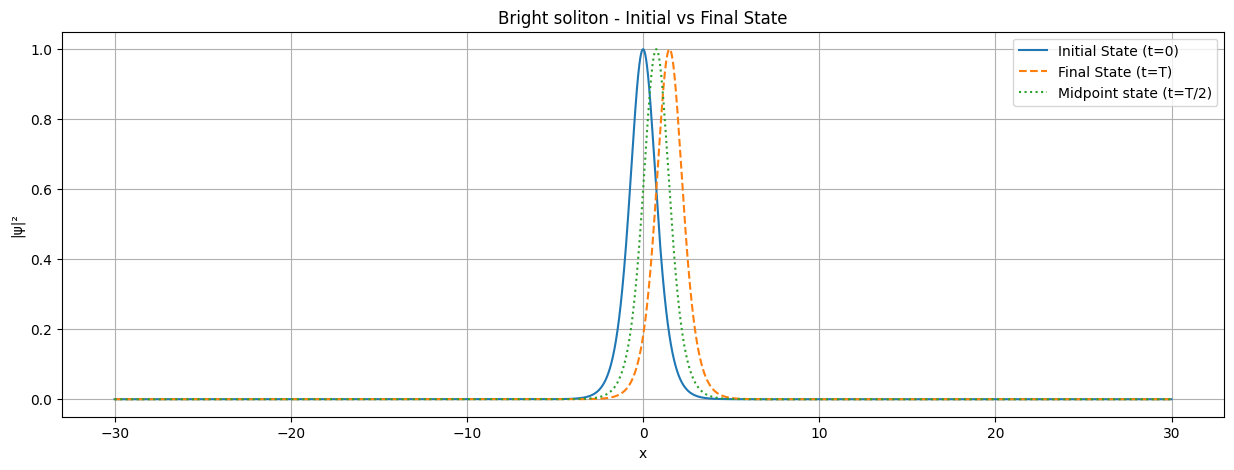

In [24]:
#Obtain the data for the final and midpoint results to show evolution over time
final_psi = np.abs(psi_results[-1])
mid_psi_state = np.abs(psi_results[len(psi_results) // 2])

#Plot time evolution of psi
plt.figure(figsize=(15,5))
plt.plot(x, np.abs(psi_0)**2, label="Initial State (t=0)")
plt.plot(x, final_psi**2, label="Final State (t=T)", linestyle="--")
plt.plot(x, mid_psi_state**2, label="Midpoint state (t=T/2)", linestyle = ":")
plt.xlabel("x")
plt.ylabel("|ψ|²")
plt.title("Bright soliton - Initial vs Final State")
plt.legend()
plt.grid(True)
plt.show()

From the figure above, it is clear that all profiles exhibit the same shape, with no change in amplitude or width over time. Each solution is shifted to the right by an equal amount, clearly showing the soliton moving with a constant velocity. This matches the soliton theory that the wave moves without change in shape - caused by the balance of the dispersion and nonlinear terms. 

These SSFM results will be used as a benchmark for the upcoming physics informed neural networks. 

## Neural Network

In this section, instead of advancing in time, the neural netork is trained to satisfy the initial and boundary condition, and reduce the residual towards zero. Once trained the PINN will provide an approximation of the solution that can be evaluuated at points (x,t) and compared against the SSFM. 

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Dense #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore

#Use tanh activation function for smooth derivatives
def create_NN():
    model = Sequential([
        Dense(128, activation = "tanh", input_shape=(2,)),
        Dense(64, activation = "tanh"),
        Dense(64, activation = "tanh"),
        Dense(2)
    ])

    return model

pinn = create_NN()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Training Data: Residual Points, Initial and Boundary Conditions

The purpose of this section is to define points where the neural network will be evaulated, and points where it will be constrained. 

The PDE residual points sample the full space. The neural network is trained to minimise the residual so that the final solution fits the PDE with minimal loss. 

The initial conditions are enforced by sampling the spatial domain at fixed t=0, where the exact solution is known. The network is trained to match the real and imaginary parts of this soliton solution, ensuring the initial conditions are met. Similarly, periodic boundary conditions are enforced. The network is trained so that the outputs at the boundaries match, and we sample points at each boundary over the entire time interval. 

All the sampled data is converted into TensorFlow tensors so that automatic differentiation can be applied later.

In [26]:
#Define the same domain to match the SSFM
x_min = -L/2
x_max = L/2
t_min = 0.0
t_max = T

##PDE residual points
n_points = 3000

x_pinn = np.random.uniform(x_min, x_max, (n_points,1))
t_pinn = np.random.uniform(t_min, t_max, (n_points,1))

#Form input pairs and convert to Tensorflow tensors
X_pinn = np.concatenate((x_pinn, t_pinn), axis=1)
X_pinn_tf = tf.convert_to_tensor(X_pinn, dtype=tf.float32)

##Initial condition points
n_ic = 500

#Sample x points while fixing t=0
x_ic = np.random.uniform(x_min, x_max, (n_ic,1))
t_ic = np.zeros((n_ic, 1))

#Form input pairs
ic_input = np.concatenate((x_ic, t_ic), axis=1)
ic_input_tf = tf.convert_to_tensor(ic_input, dtype=tf.float32)

#Initial condition of the soliton at t=0
psi_ic = A * sech(B * x_ic) * np.exp(1j * k0 * x_ic)

#Split real and complex parts and convert to tensors
u_ic = np.real(psi_ic)
v_ic = np.imag(psi_ic)

u_ic_tf = tf.convert_to_tensor(u_ic, dtype=tf.float32)
v_ic_tf = tf.convert_to_tensor(v_ic, dtype=tf.float32)

#Periodic boundary conditions
n_bc = 500

t_bc = np.random.uniform(t_min, t_max, (n_bc,1))

#Fix x positions at each boundary
x_left = x_min * np.ones((n_bc, 1))
x_right = x_max * np.ones((n_bc, 1))

#Create input pairs at each boundary and convert to tensors.
x_bc_left = np.concatenate((x_left, t_bc), axis=1)
x_bc_right = np.concatenate((x_right, t_bc), axis=1)

x_bc_left_tf = tf.convert_to_tensor(x_bc_left, dtype=tf.float32)
x_bc_right_tf = tf.convert_to_tensor(x_bc_right, dtype = tf.float32)



### Defining the NLS residual

The Nonlinear Schrodinger Equation must be written in a form suitable for the PINN. This is achieved by equating real and imaginary components and defining the NLS residuals. We start by writing the NLS into its real and imaginary parts. $$\psi(x,t) = u(x,t) + i\,v(x,t)$$

A full derivation of the residuals will be included in the derivations folder. The result is two coupled PDEs.

$$u_t + \frac{1}{2} v_{xx} + \left(u^2 + v^2\right) v = 0$$

$$v_t - \frac{1}{2} u_{xx} - \left(u^2 + v^2\right) u = 0$$

These equations will inform us how well the neural network fits the expected result. For a more accurate solution, the residual would tend to zero. 

In [27]:
def residual(model, x, t):

    #Use GradientTape with persistent = True since calculating multiple derivatives
    with tf.GradientTape(persistent=True) as tape:
        #Tensorflow tracks x and t
        tape.watch(x)
        tape.watch(t)

        #Concatenate and pass data through the neural network
        model_input = tf.concat([x, t], axis=1)
        model_results = model(model_input)

        u = model_results[:, 0:1] #real part
        v = model_results[:, 1:2] #imaginary part

        #Calculate first order derivatives
        u_t = tape.gradient(u,t)
        v_t = tape.gradient(v,t)
        u_x = tape.gradient(u,x)
        v_x = tape.gradient(v,x)

        #Second order derivatives
        u_xx = tape.gradient(u_x,x)
        v_xx = tape.gradient(v_x,x)

    del tape

    #Define the residuals
    f_u = u_t + 0.5 * v_xx + (u**2 + v**2) * v
    f_v = v_t - 0.5 * u_xx - (u**2 + v**2) * u

    return f_u, f_v        

### Defining the loss function

The PINN is trained by a singular loss function, but this will be composed of three individual parts - the PDE residual loss, the initial condition loss, and the Boundary condition loss.

PDE residual loss - Random points are sampled. The mean squared value of the residual is minimised so that the Neural Network satisfies the PDE everywhere in the domain. 

Initial condition loss - The initial condition is known. The neural network is trained so that it evolves from the correct initial state. 

Boundary condition loss - Periodic boundary conditions enforced, ensuring the solution is accurate at the edges of the spatial and temporal domains. 



In [28]:
def residual_loss(model, X_pinn_tf):

    #Split into space and time components
    x = X_pinn_tf[:, 0:1]
    t = X_pinn_tf[:, 1:2]

    f_u, f_v = residual(model, x, t)

    #mean squared error of the residuals
    loss = tf.reduce_mean(tf.square(f_u)) + tf.reduce_mean(tf.square(f_v))

    return loss

def initial_loss(model, ic_input_tf, u_ic_tf, v_ic_tf):

    #model predictions at the initial points
    pred = model(ic_input_tf)

    #Real and imaginary components
    u_pred = pred[:, 0:1]
    v_pred = pred[:, 1:2]

    #Mean squared error with the initial condition
    loss_u = tf.reduce_mean(tf.square(u_pred - u_ic_tf))
    loss_v = tf.reduce_mean(tf.square(v_pred - v_ic_tf))

    return loss_u + loss_v 

def boundary_loss(model, x_bc_left_tf, x_bc_right_tf):

    #Model prediction at left and right boundary
    pred_l = model(x_bc_left_tf)
    pred_r = model(x_bc_right_tf)

    #Split the real and imaginary parts at each boundary
    u_l = pred_l[:, 0:1]
    v_l = pred_l[:, 1:2]

    u_r = pred_r[:, 0:1]
    v_r = pred_r[:, 1:2]

    #Minimise difference between left and right boundaries
    loss_u = tf.reduce_mean(tf.square(u_l - u_r))
    loss_v = tf.reduce_mean(tf.square(v_l - v_r))

    return loss_u + loss_v

def loss_function(model, X_pinn_tf, ic_input_tf, u_ic_tf, 
                  v_ic_tf, x_bc_left_tf, x_bc_right_tf):
    
    resid_loss = residual_loss(model, X_pinn_tf)
    init_loss = initial_loss(model, ic_input_tf, u_ic_tf, v_ic_tf)
    bound_loss = boundary_loss(model, x_bc_left_tf, x_bc_right_tf)

    resid_weight = 1.0
    init_weight = 10.0
    bound_weight = 1.0
    

    #Total loss is the sum
    return (resid_weight * resid_loss) + (init_weight * init_loss) + (bound_weight * bound_loss)


Introduce the code to train the PINN using the Adam optimiser with a fixed learning rate. The Adam optimiser computes gradient descent automatically, from the loss function previously coded. 

In [29]:
#Use Adam Optimiser
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

#Number of training iterations
runs = 3000
print_every = 500

for run in range(runs):

    with tf.GradientTape() as tape:

        #Compute total loss
        loss = loss_function(pinn, X_pinn_tf, ic_input_tf, u_ic_tf, v_ic_tf, x_bc_left_tf, x_bc_right_tf)

    #Compute gradients of the loss with the input parameters
    grads = tape.gradient(loss, pinn.trainable_variables)

    #Update the network
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))

    if run % print_every == 0:
        print(f"Run {run}: Loss = {loss.numpy():.6e}")


Run 0: Loss = 1.105752e+02
Run 500: Loss = 3.139604e-02
Run 1000: Loss = 5.889312e-03
Run 1500: Loss = 2.140119e-03
Run 2000: Loss = 1.145156e-03
Run 2500: Loss = 7.457680e-04


## Comparison with SSFM

In [30]:
#Times to compare the PINN with the SSFM
t0 = 0.0
t_mid = T / 2
t_final = T

#Convert x into column vector so it can be combined with t values
x_col = x.reshape(-1, 1)

def pinn_slice(model, x, t_value):

    #Create a time column vector
    t_col = t_value * np.ones_like(x)

    #Combine x and t into input pairs and convert to a Tensorflow Tensor
    XT = np.concatenate((x, t_col), axis=1)
    XT_tf = tf.convert_to_tensor(XT, dtype=tf.float32)


    pred = model(XT_tf)
    
    #Obtain real and imaginary parts
    u = pred[:, 0].numpy()
    v = pred[:, 1].numpy()

    #Return the |psi|**2 value for comparison
    return np.abs(u + 1j * v)**2


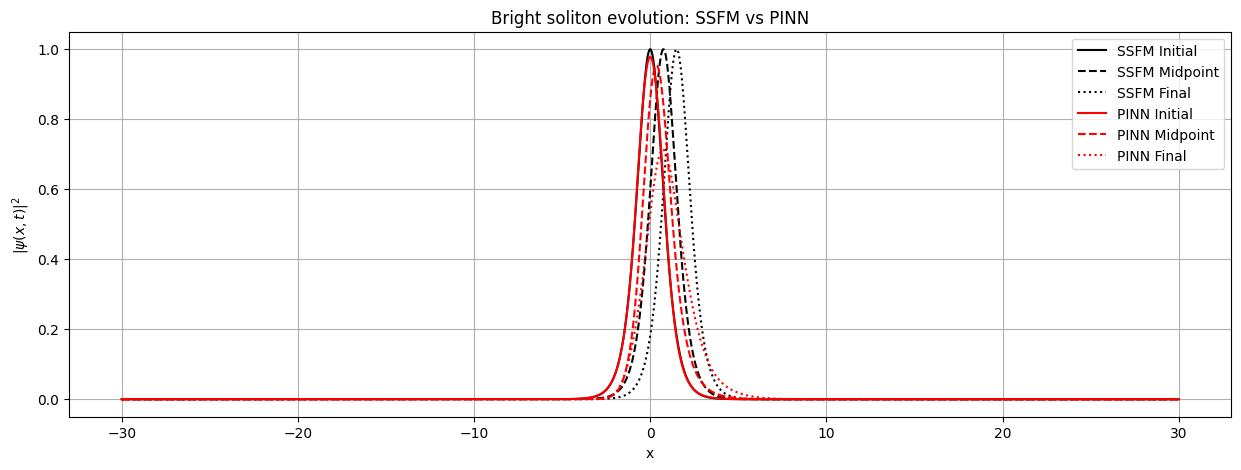

In [31]:
#Obtain initial, mid and final PINN solutions for plotting
pinn_initial = pinn_slice(pinn, x_col, t0)
pinn_mid = pinn_slice(pinn, x_col, t_mid)
pinn_final = pinn_slice(pinn, x_col, t_final)

#Renormalise to try preserve amplitude of the soliton
def renormalise(u, x, target_norm):
    current_norm = np.trapezoid(u, x)
    return u * (target_norm / current_norm)

#Use SSFM solution as a reference
target_norm = np.trapezoid(np.abs(psi_0)**2, x)

#Apply renormalisation to the PINN
pinn_initial = renormalise(pinn_initial, x, target_norm)
pinn_mid     = renormalise(pinn_mid, x, target_norm)
pinn_final   = renormalise(pinn_final, x, target_norm)

plt.figure(figsize=(15,5))

#SSFM original plot
plt.plot(x, np.abs(psi_0)**2, color="black", label="SSFM Initial")
plt.plot(x, mid_psi_state**2, color="black", linestyle = "--", label="SSFM Midpoint")
plt.plot(x, final_psi**2, color="black", linestyle = ":", label="SSFM Final")

#PINN plot at matching times
plt.plot(x, pinn_initial, color="red", label="PINN Initial")
plt.plot(x, pinn_mid, color="red", linestyle = "--", label="PINN Midpoint")
plt.plot(x, pinn_final, color="red", linestyle = ":", label="PINN Final")

plt.xlabel("x")
plt.ylabel(r"$|\psi(x,t)|^2$")
plt.title("Bright soliton evolution: SSFM vs PINN")
plt.legend()
plt.grid(True)
plt.show()

The PINN is able to capture the reproduce the soliton shape and propagation speed to relatively high accuracy, however a gradual decrease in peak amplitude is observed as time passes. This is a known limitation of PINNs, where conservation of mass and energy are not specifically enforced during training. In contrast, the split-step fourier method preserves these by constructing the shape at each step. Despite this, it is still fascinating how the general shape and speed of the soliton solution to a complex PDE can easily be simulated. 

## Conclusion

In this project, a Physics-Informed Neural Network was developed to solve the 1D focusing nonlinear Schrodinger Equation, benchmarked against the split-step Fourier method. The PINN was able to reproduce the soliton profile and its time evolution, demonstrating the power of neural networks for solving difficult mathematical problems. While the method did struggle with conserving amplitude of the soliton - due to conservation laws regarding other properties, these can be overcome with more extensive training and tuning of the models. The conservation laws can explicitly be encoded into the training of the model, or alternative libraries more suited for long-term dynamic systems could be used. Furthermore, I had to reduce the number of epochs due to time constraints - however if more accurate solutions are desired then these can be increased tenfold. Overall, this work shows the potential of PINNs as a flexible alternative to standard numerical methods, with a lot of space for improvement. 

## References 

[1]: Vincent Thacker (2024): https://physics.stackexchange.com/questions/563907/soliton-solution-of-the-nls-equation?

[2]: YourFavouriteTA (2022): https://www.youtube.com/watch?v=xIdozUy9Nas&t=298s

[3]: Stéphane Descombes, Mechthild Thalhammer (2011): https://hal.science/hal-00557593v1/document

[4]: Visuara (2025): https://www.youtube.com/watch?v=1AyAia_NZhQ
